## Connect to MLFlow tracking server that requires authentication

In [1]:
#import required libraries

import mlflow
import os

import tensorflow as tf
import numpy
from tensorflow import keras
from keras.constraints import maxnorm
from keras.utils import np_utils
from matplotlib import pyplot

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#set authentication
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'.\serviceAccount.json'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'name'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'

#mlflow server url
TRACKING_URI = "https://mlflow-server-"
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment("balance_body")

<Experiment: artifact_location='gs://aiteam-mlflow-storage-bucket/models/2', creation_time=1684292939752, experiment_id='2', last_update_time=1684293108622, lifecycle_stage='active', name='balance_body', tags={}>

In [4]:
seed = 21

# prepare the data
from keras.datasets import cifar10
# Loading in the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


#### class
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck

c:\Users\Admin\Anaconda3\envs\gliter\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


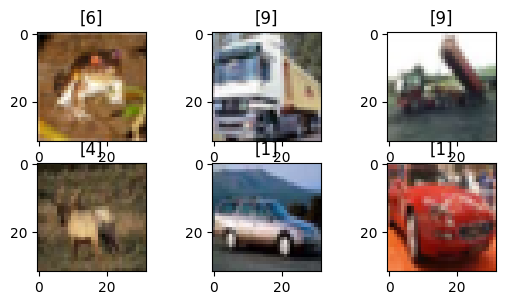

In [5]:
# plot first few images
for i in range(6):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 pyplot.title(y_train[i])
 # plot raw pixel data
 pyplot.imshow(X_train[i])
# show the figure
pyplot.show()

In [6]:
# Normalize the inputs from 0-255 to between 0 and 1 by dividing by 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
# One-hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

In [12]:
# create the Model
model = keras.Sequential([

tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=X_train.shape[1:], activation='relu'),
tf.keras.layers.Conv2D(32, 3, activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
tf.keras.layers.Conv2D(64, 3, activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.25),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(class_num, activation='softmax')])


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        36928     
                                                      

In [18]:
### MLflow

In [17]:
with mlflow.start_run():
    params = {
    "batch_size" : 8,
    "model_name" : "CNN",
    "epoch" : 3,
    "train_size" : len(X_train),
    "test_size" : len(X_test),
    "img_size" : 32, 

    "date" : "17-5-2023 : 2:00 PM",
    "data source" : "cifar10"
    }
    mlflow.set_tag("developer","khantkhant")
    mlflow.log_params(params)

    mlflow.tensorflow.autolog()
    history = model.fit(X_train, y_train, epochs=5, batch_size=32,  verbose=0)
    mlflow.tensorflow.log_model(model, artifact_path="simple-cnn")

2023/05/17 13:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'batch_size', 'old_value': '8', 'new_value': '32'}]' for run ID='4bb9a5afa4bb494fbf8e8a4834ab08ff'.
2023/05/17 13:34:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpc8s6zw9g\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpc8s6zw9g\model\data\model\assets
c:\Users\Admin\Anaconda3\envs\gliter\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [19]:
# Model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.52%


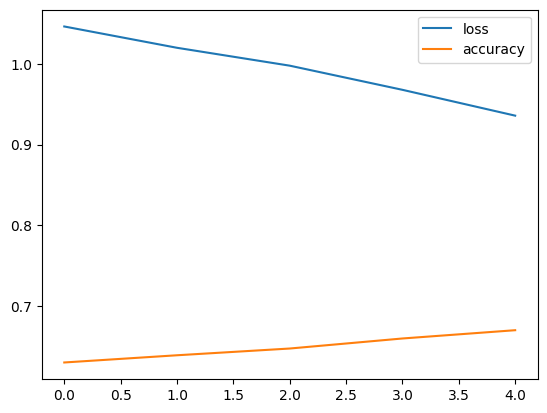

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()